In [1]:
import numpy as np
from scipy.integrate import solve_ivp
from dynamical_systems.SIR_Identifiable import *
import matplotlib.pyplot as plt

### Solve SIR Identifiable Dynamics

In [2]:
x0 = np.array([900,100,0]) # initial condition
true_theta_dyn = np.array([0.02,0.6,0.15]) # True parameters
t_eval = np.linspace(0,6,61)

sol = solve_SIR_forward(true_theta_dyn, sir_dynamics_identifiable, t_eval, x0)

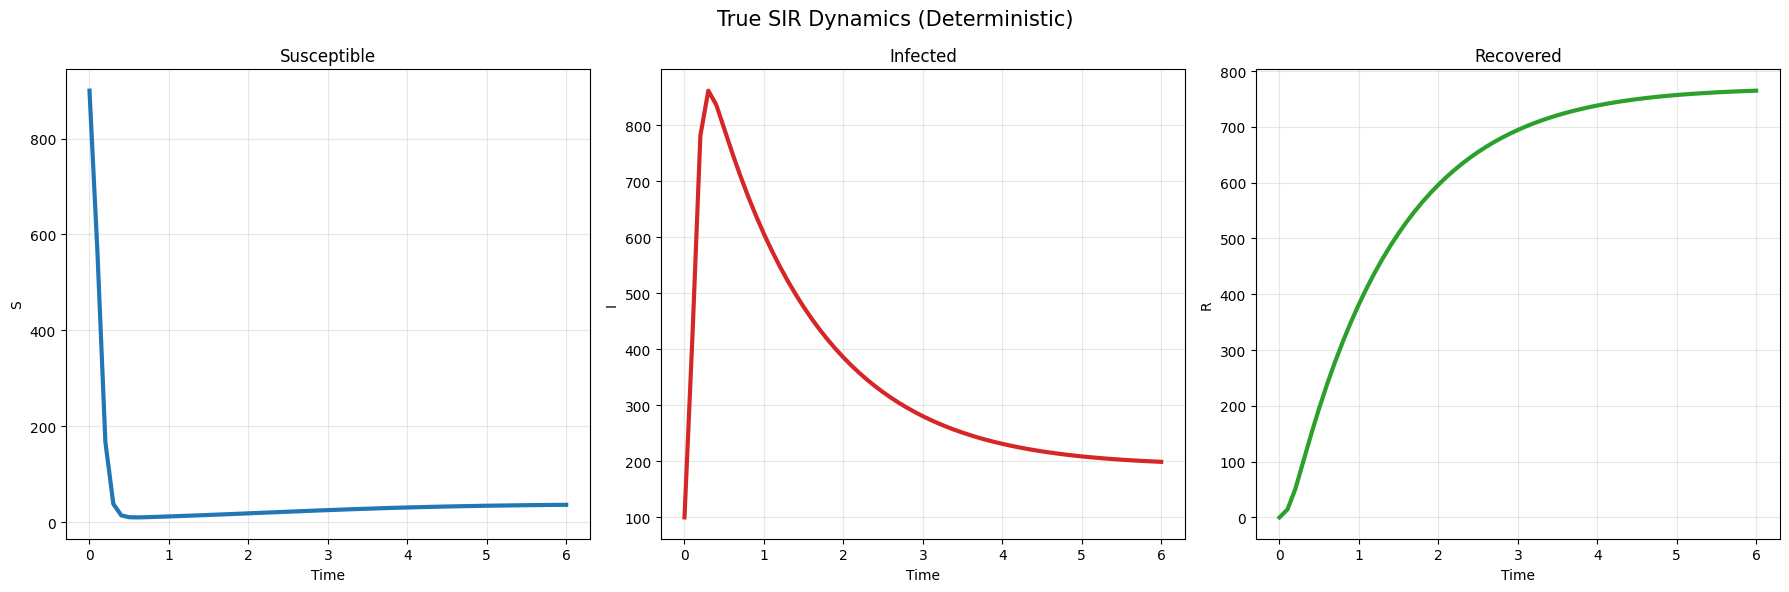

In [3]:
fig, axs = plt.subplots(1, 3, figsize=(18, 6), sharex=True)

states = ['Susceptible', 'Infected', 'Recovered']
colors = ['tab:blue', 'tab:red', 'tab:green']
ylabels = ['S', 'I', 'R']

for i, ax in enumerate(axs):
    ax.plot(sol.t, sol.y[i], color=colors[i], lw=3)
    ax.set_title(states[i])
    ax.set_ylabel(ylabels[i])
    ax.set_xlabel('Time')
    ax.grid(alpha=0.3)

fig.suptitle('True SIR Dynamics (Deterministic)', fontsize=15)
plt.tight_layout()
plt.show()

## Generate Sensor Data

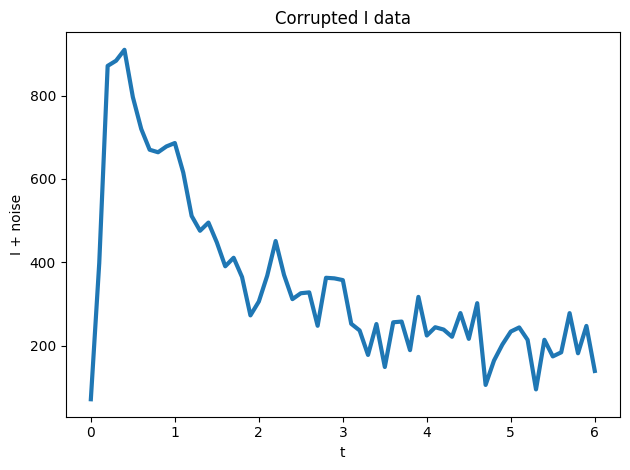

In [4]:
num_points = 61
process_std = 50
whitenoise = process_std*np.random.randn(num_points)
corrupted_I = sol.y[1] + whitenoise

plt.plot(sol.t, corrupted_I, linewidth=3.0)
plt.xlabel('t');plt.ylabel('I + noise')
plt.title("Corrupted I data")
plt.tight_layout()
plt.show()

# Laplace Approximation for SIR Identifiable

In [5]:
prior_mean = np.zeros(3)
prior_cov = np.identity(3)

logpost = lambda params: log_posterior_SIR(params, 
                                           corrupted_I, 
                                           process_std,
                                           t_eval, 
                                           sir_dynamics_identifiable, 
                                           prior_mean, 
                                           prior_cov)

guess = np.array([0,0,0]) # random guess
# guess = np.random.randn((3)) # random guess
map_point, cov_laplace = laplace_approx(guess, logpost)
print("map Point = ", map_point)
print("Laplace Covariance = \n" , cov_laplace)

map Point =  [0.02124594 0.61372436 0.15173493]
Laplace Covariance = 
 [[ 1.99127152e-06 -2.38912509e-06 -1.72950296e-06]
 [-2.38912509e-06  6.63998232e-04  3.66696167e-04]
 [-1.72950296e-06  3.66696167e-04  3.02136518e-04]]


## Apply DRAM for SIR Model

In [6]:
from mcmc.algorithms.dram import *
from mcmc.utils.mcmc_utils import *
from mcmc.diagnostics.autocorrelation import *
from mcmc.utils.run_helpers import *
from mcmc.diagnostics.iac_and_ess import *

In [7]:
target_logpdf = lambda x : log_posterior_SIR(x,
                                             corrupted_I,
                                             process_std,
                                             t_eval,
                                             sir_dynamics_identifiable,
                                             prior_mean,
                                             prior_cov)

val = target_logpdf(true_theta_dyn)
print(val, type(val), np.shape(val))

-34.67302257936922 <class 'numpy.float64'> ()


In [8]:
target_logpdf = lambda x : log_posterior_SIR(x,
                                             corrupted_I,
                                             process_std,
                                             t_eval,
                                             sir_dynamics_identifiable,
                                             prior_mean,
                                             prior_cov)

# initial conditions
initial_sample = map_point
initial_cov = cov_laplace # from Laplace Approximation
num_samples = 100000

# Proposal Distribution properties
proposal_logpdf = proposal_mvn_logpdf_eval
proposal_sampler = proposal_mvn_sampler

## Deyaled Rejection
dram_samples = dram_mcmc(initial_sample, initial_cov, num_samples, target_logpdf, proposal_logpdf, proposal_sampler, k0=2000, freq_of_update=500, verbose=True)

samples = dram_samples.samples
print("Accepted Samples Ratio:", dram_samples.accept_rate)

Finished sample 1000, acceptance ratio = 0.784
Finished sample 2000, acceptance ratio = 0.784
Finished sample 3000, acceptance ratio = 0.746
Finished sample 4000, acceptance ratio = 0.727
Finished sample 5000, acceptance ratio = 0.720
Finished sample 6000, acceptance ratio = 0.711
Finished sample 7000, acceptance ratio = 0.708
Finished sample 8000, acceptance ratio = 0.704
Finished sample 9000, acceptance ratio = 0.700
Finished sample 10000, acceptance ratio = 0.698
Finished sample 11000, acceptance ratio = 0.694
Finished sample 12000, acceptance ratio = 0.692
Finished sample 13000, acceptance ratio = 0.688
Finished sample 14000, acceptance ratio = 0.687
Finished sample 15000, acceptance ratio = 0.685
Finished sample 16000, acceptance ratio = 0.684
Finished sample 17000, acceptance ratio = 0.683
Finished sample 18000, acceptance ratio = 0.682
Finished sample 19000, acceptance ratio = 0.681
Finished sample 20000, acceptance ratio = 0.679
Finished sample 21000, acceptance ratio = 0.676
F

In [9]:
new_mh_result= mcmc_burnin_and_thin(dram_samples, burnin_frac=0.5, thin_frac=1)
samples = new_mh_result.samples
print("Accepted Samples Ratio:", new_mh_result.accept_rate)

Accepted Samples Ratio: 0.65434


In [17]:
print(np.sum(samples, axis=0)/samples.shape[0])

[0.02164596 0.62029555 0.15553876]


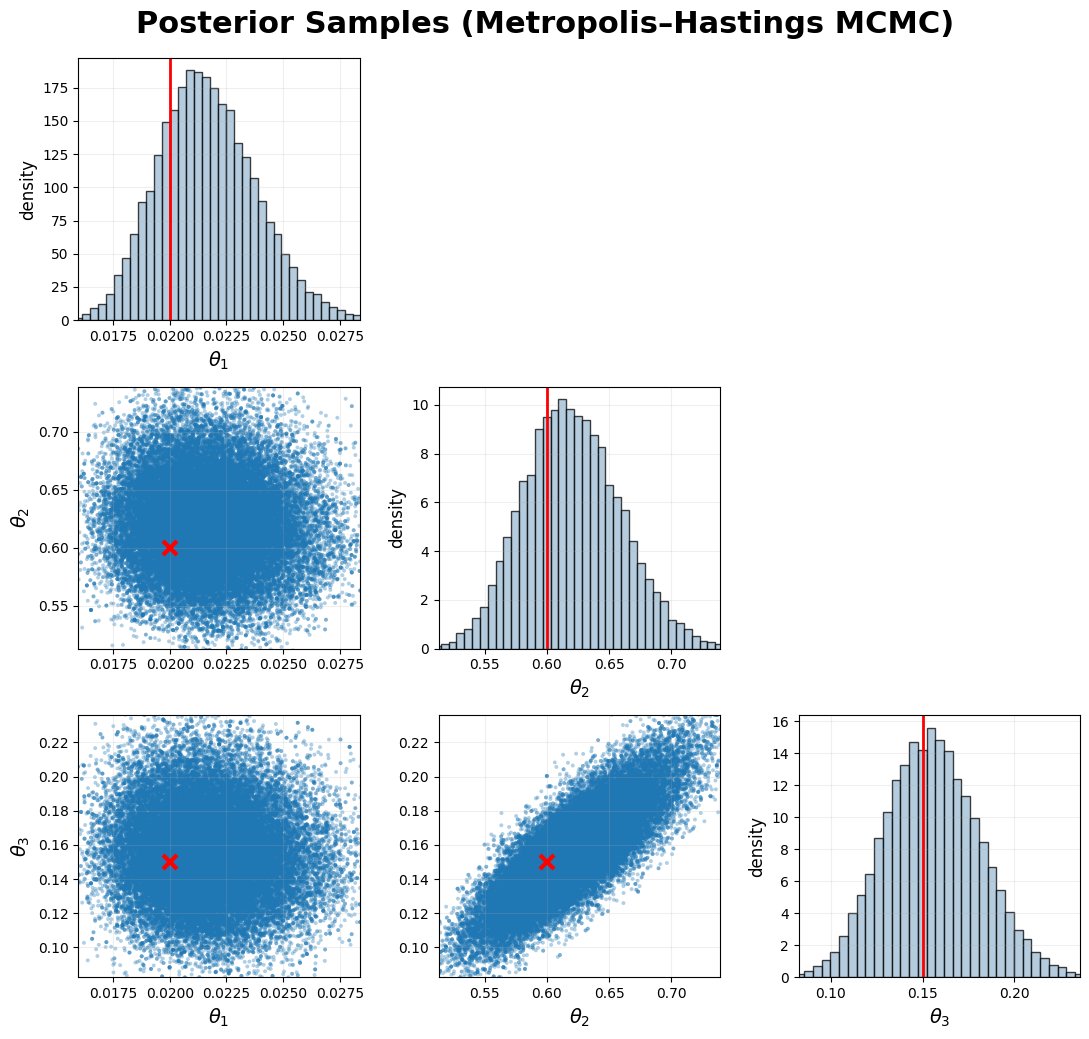

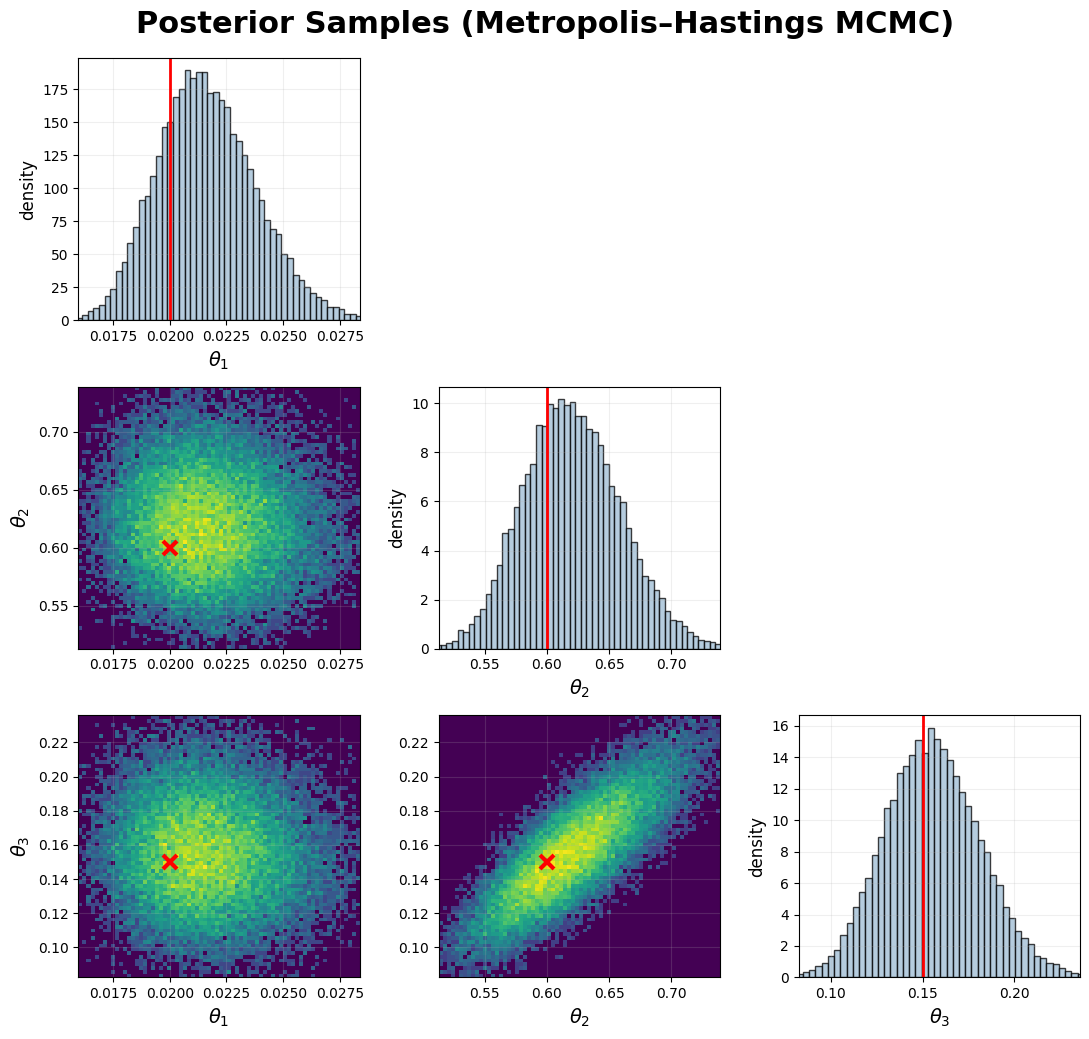

In [18]:
plt.close()
fig, axs, gs = scatter_matrix_clean(
    11,
    [samples],
    truths=true_theta_dyn,          # or None
    labels=[r"$\theta_1$", r"$\theta_2$", r"$\theta_3$"],
    hist_plot=False,
)
plt.show()

plt.close(12)
fig, axs, gs = scatter_matrix_clean(
    12,
    [samples],
    truths=true_theta_dyn,
    labels=[r"$\theta_1$", r"$\theta_2$", r"$\theta_3$"],
    hist_plot=True,
    nbins=70
)
plt.show()

Text(0.5, 0.98, 'SIR Identifiable DRAM Mixing')

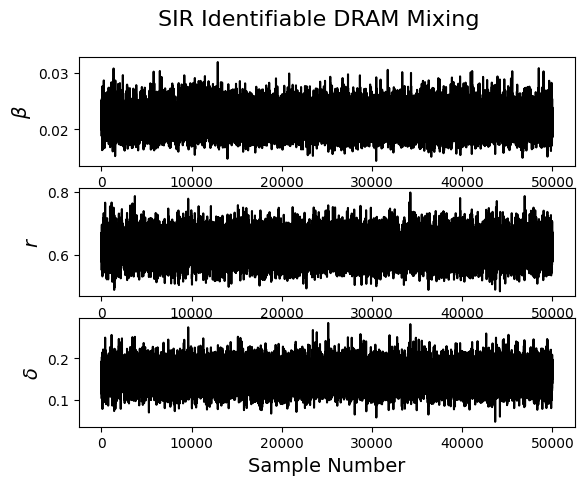

In [19]:
plt.close(4)
fig, axs = plt.subplots(3, 1, num=4)
axs[0].plot(samples[:, 0], '-k')
axs[0].set_ylabel(r'$\beta$', fontsize=14)
axs[1].plot(samples[:, 1], '-k')
axs[1].set_ylabel(r'$r$', fontsize=14)
axs[2].plot(samples[:, 2], '-k')
axs[2].set_ylabel(r'$\delta$', fontsize=14)
axs[2].set_xlabel('Sample Number', fontsize=14)
fig.suptitle('SIR Identifiable DRAM Mixing', fontsize=16)

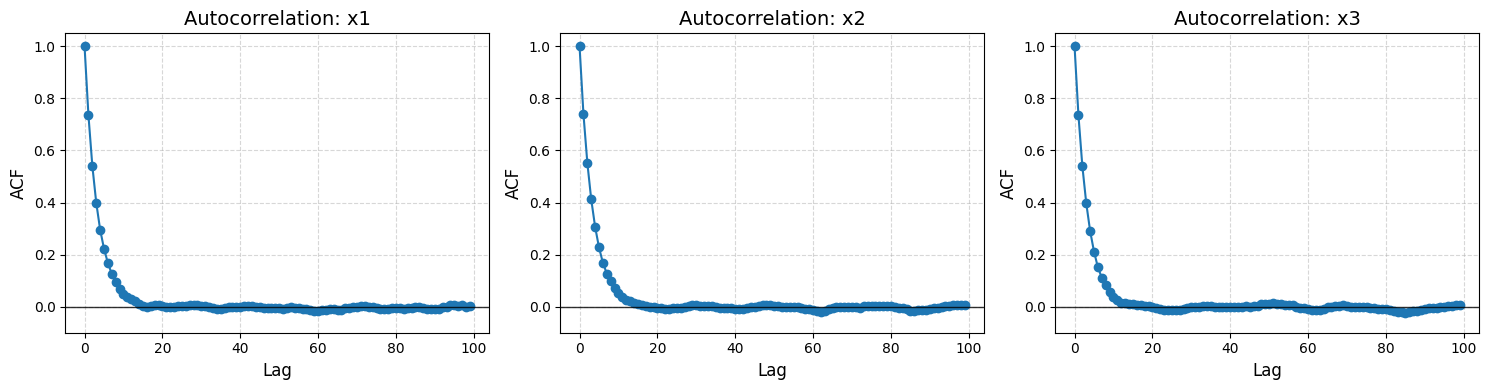

In [20]:
lags, acf = autocorrelation_vectorized(samples, max_lag=100)
plot_autocorrelation_3d(lags, acf, dim_names=("x1", "x2", "x3"))

In [21]:
iac, acf, lags = integrated_autocorrelation(samples, max_lag=300)
ess = effective_sample_size(samples, iac)

N = samples.shape[0]
efficiency = ess / N * 100  # percentage

print(f"Total samples: {N}\n")

for k in range(len(iac)):
    print(f"Dimension {k}:")
    print(f"  IAC:          {iac[k]:.4f}")
    print(f"  ESS:          {ess[k]:.2f}")
    print(f"  Efficiency:   {efficiency[k]:.1f}%   "
          f"({efficiency[k]:.1f}% as effective as independent samples)")
    print()

Total samples: 50000

Dimension 0:
  IAC:          6.6050
  ESS:          7570.01
  Efficiency:   15.1%   (15.1% as effective as independent samples)

Dimension 1:
  IAC:          6.7531
  ESS:          7403.98
  Efficiency:   14.8%   (14.8% as effective as independent samples)

Dimension 2:
  IAC:          6.4132
  ESS:          7796.40
  Efficiency:   15.6%   (15.6% as effective as independent samples)

